In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [2]:
plt.rcParams['font.family'] = 'NanumGothic'

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv('../Data/train_preprocess.csv')
test = pd.read_csv('../Data/test_preprocess.csv')
valid = pd.read_csv('../Data/valid_preprocess.csv')

print(train.shape)
print(test.shape)
print(valid.shape)

train.sample()

(59191, 33)
(2957, 32)
(6898, 33)


id    tag  year  month  day dayofweek year-month year-month-day  \
56754  77674  train  2015     12    8   Tuesday    2015-12     2015-12-08   

       hour  minute  ...  cctv_dstnc cctv_in_100m  fr_mn_cnt  \
56754    17      13  ...          69            7      108.0   

       fr_wthr_fclt_in_100m  tbc_rtl_str_dstnc  sft_emrgnc_bll_dstnc  \
56754                     1               2058                 80976   

       ahsm_dstnc no_tbc_zn_dstnc bldng_cnt_in_50m fire_yes  
56754         159             130                1    False  

[1 rows x 33 columns]

## Null 값 확인

In [5]:
train.isnull().sum()
test.isnull().sum()
valid.isnull().sum()

id                      0
tag                     0
year                    0
month                   0
day                     0
dayofweek               0
year-month              0
year-month-day          0
hour                    0
minute                  0
second                  0
jmk                     0
mlt_us_yn(encode)       0
tmprtr                  0
wnd_spd                 0
wnd_drctn               0
hmdt                    0
address                 0
address1                0
address2                0
hm_cnt                  0
fr_sttn_dstnc           0
fr_wthr_fclt_dstnc      0
cctv_dstnc              0
cctv_in_100m            0
fr_mn_cnt               0
fr_wthr_fclt_in_100m    0
tbc_rtl_str_dstnc       0
sft_emrgnc_bll_dstnc    0
ahsm_dstnc              0
no_tbc_zn_dstnc         0
bldng_cnt_in_50m        0
fire_yes                0
dtype: int64

## train, test, valid 데이터 합치기
화재발생여부 제외한 컬럼간 관계 보기 위해서

In [6]:
columns = ['id', 'tag'
           # 날짜
           , 'year', 'month', 'day', 'dayofweek', 'year-month', 'year-month-day', 'hour', 'minute', 'second'
          # 건물 용도
           , 'jmk'
          # 건물 용도 (전처리 안됨)
#            , 'bldng_us', 'bldng_archtctr', 'bldng_us_clssfctn', 'dt_of_athrztn'
          # 건물 정보 (전처리 안됨)
#            , 'bldng_ar', 'ttl_ar', 'lnd_ar', 'ttl_grnd_flr', 'ttl_dwn_flr'
           # 다중이용업소
           , 'mlt_us_yn(encode)'
          # 날씨 정보
           , 'tmprtr', 'wnd_spd', 'wnd_drctn', 'hmdt'
          # 행정구역 정보
           , 'address', 'address1', 'address2', 'hm_cnt'
          # 도심과 가까운 정도
           , 'fr_sttn_dstnc', 'fr_wthr_fclt_dstnc', 'cctv_dstnc', 'cctv_in_100m', 'fr_mn_cnt'
           , 'fr_wthr_fclt_in_100m', 'tbc_rtl_str_dstnc', 'sft_emrgnc_bll_dstnc', 'ahsm_dstnc'
           , 'no_tbc_zn_dstnc', 'bldng_cnt_in_50m'
          # 화재발생 여부
#            , 'fire_yes'
          ]

df = pd.concat([train.drop('fire_yes', axis=1), test, valid.drop('fire_yes', axis=1)])
df = df[columns]
print(df.shape)
df.columns

(69046, 32)


Index(['id', 'tag', 'year', 'month', 'day', 'dayofweek', 'year-month',
       'year-month-day', 'hour', 'minute', 'second', 'jmk',
       'mlt_us_yn(encode)', 'tmprtr', 'wnd_spd', 'wnd_drctn', 'hmdt',
       'address', 'address1', 'address2', 'hm_cnt', 'fr_sttn_dstnc',
       'fr_wthr_fclt_dstnc', 'cctv_dstnc', 'cctv_in_100m', 'fr_mn_cnt',
       'fr_wthr_fclt_in_100m', 'tbc_rtl_str_dstnc', 'sft_emrgnc_bll_dstnc',
       'ahsm_dstnc', 'no_tbc_zn_dstnc', 'bldng_cnt_in_50m'],
      dtype='object')

## correlation

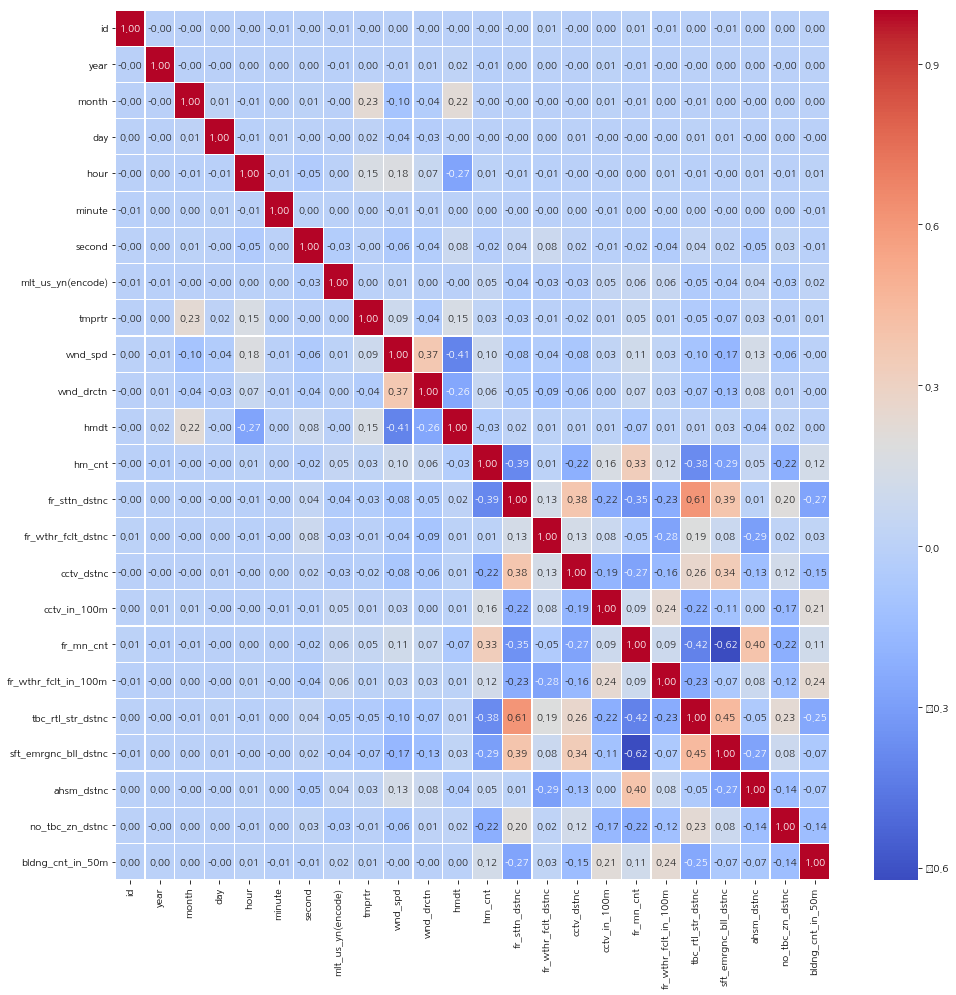

In [7]:
# 화재발생여부 제외한 전체 데이터 correlation
plt.figure(figsize=[16, 16])
sns.heatmap(df.corr(), annot=True, fmt = '.2f', linewidths=0.2, cmap='coolwarm')

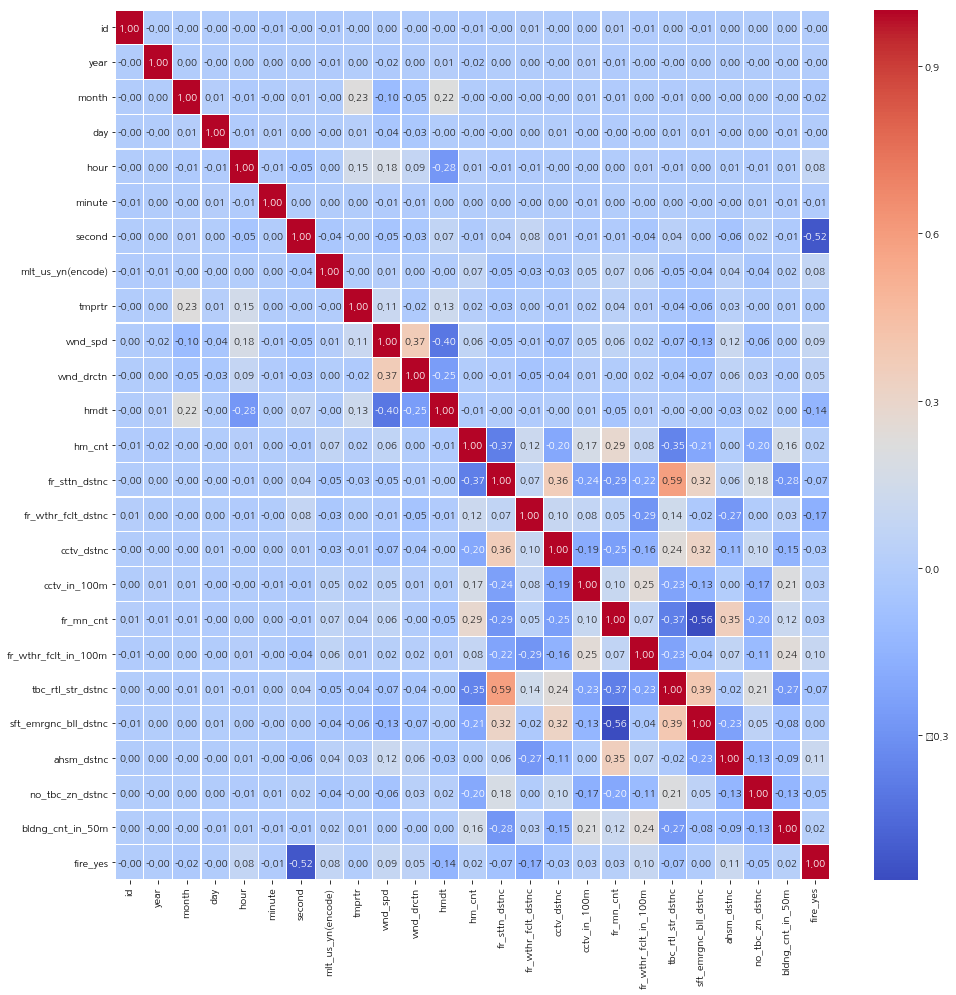

In [8]:
# train 데이터 fire_yes 와의 correlation
plt.figure(figsize=[16, 16])
sns.heatmap(train.corr(), annot=True, fmt = '.2f', linewidths=0.2, cmap='coolwarm')

### train 데이터 fire_yes 와의 correlation
- month -0.02
- hour 0.078
- second -0.52 (관계없음, 기록의 문제)

#### 기상상황
- wnd_spd 0.089
    - 바람이 세게 불수록
- wnd_drctn 0.051
    - 풍향 숫자로 표시된거 뭘까
- hmdt -0.14
    - 습도가 낮을수록

#### 소방시설 접근성이 높을수록 화재발생
- fr_sttn_dstnc -0.07 
    - 소방서와의 거리가 가까울수록
- fr_wthr_fclt_dstnc -0.16 
    
    - 소방용수시설과 가까울수록 화재발생
    - 가설: 불이 자주 나는 곳에 소방용수시설을 설치했기 때문 ?
    - 검증: 창원시 때문에 왜곡 발생(창원시 화재발생 0건, 다른 지역에 비해 소방용수시설과 멀다)
- fr_wthr_fclt_in_100m 0.096 
    - 100m 내 소방용수시설이 많을수록


#### cctv 관련 항목 2개는 상충된다
- cctv_dstnc -0.029
    - cctv 와의 거리가 멀수록
- cctv_in_100m 0.027
    - 100 m 내 cctv 가 많을수록
    
#### 도시와 가까울수록
- tbc_rtl_str_dstnc -0.065 
    - 담배소매점과 거리가 가까울수록
- no_tbc_zn_dstnc -0.047 
    - 금연구역과의 거리가 가까울수록
- bldng_cnt_in_50m 0.023
    - 50m 내 건물이 많을수록
- hm_cnt 0.022
    - 해당 행정구역 인구가 많을수록 화재발생

#### 자동심장제세동기 설치하는 곳은 어떤곳일까
- ahsm_dstnc 0.11 
    - 자동심장제세동기와의 거리가 멀수록 화재발생
    
#### 기타
- mlt_us_yn(encode)다중이용업소 0.074

## df['fire_yes'] == True 불이 난 날

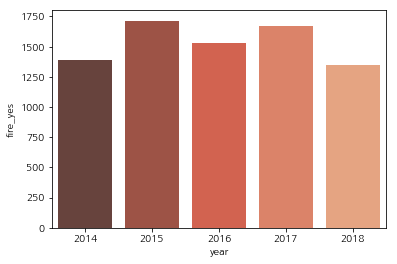

In [9]:
# 연도별 트렌드 확인
data = pd.DataFrame(train.groupby('year')['fire_yes'].sum()).reset_index()

sns.barplot(x='year', y='fire_yes', data=data, palette='OrRd_d')

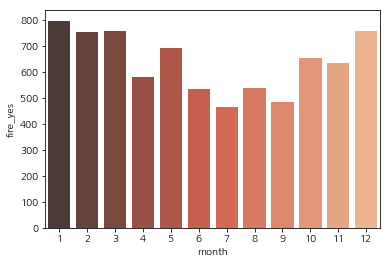

In [10]:
# 월별 트렌드 확인
data = pd.DataFrame(train.groupby('month')['fire_yes'].sum()).reset_index()

sns.barplot(x='month', y='fire_yes', data=data, palette='OrRd_d')

계절성 확인
- 여름에 줄고, 겨울에 늘어난다

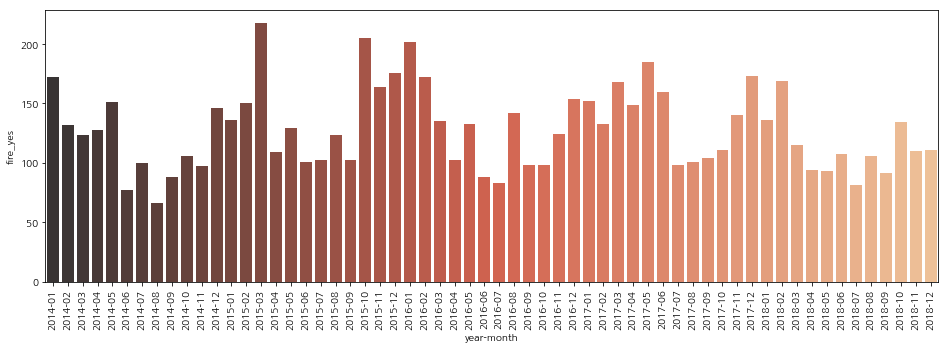

In [11]:
data = pd.DataFrame(train.groupby('year-month')['fire_yes'].sum()).reset_index()

plt.figure(figsize=[16, 5])
sns.barplot(x='year-month', y='fire_yes', data=data, palette='OrRd_d')
plt.xticks(rotation=90)
plt.show()

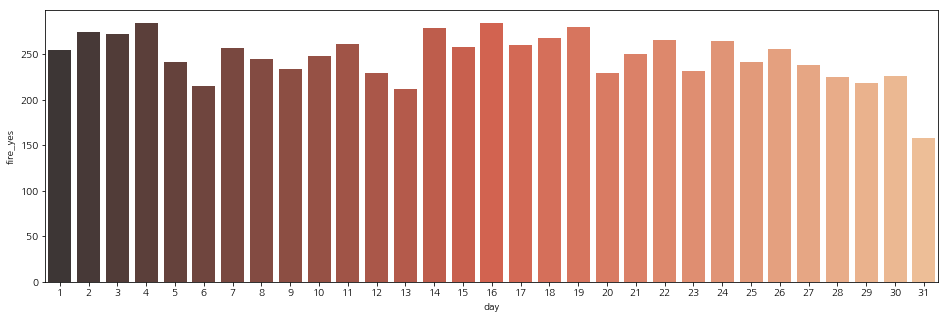

In [12]:
data = pd.DataFrame(train.groupby('day')['fire_yes'].sum()).reset_index()

plt.figure(figsize=[16, 5])
sns.barplot(x='day', y='fire_yes', data=data, palette='OrRd_d')
plt.show()

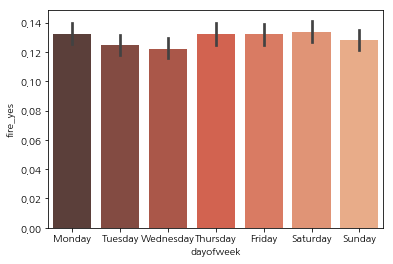

In [13]:
# 요일별 트렌드 확인
data = pd.DataFrame(train.groupby('dayofweek')['fire_yes'].sum()).reset_index()
index_weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sns.barplot(x='dayofweek', y='fire_yes', data=train, order=index_weekday, palette='OrRd_d')

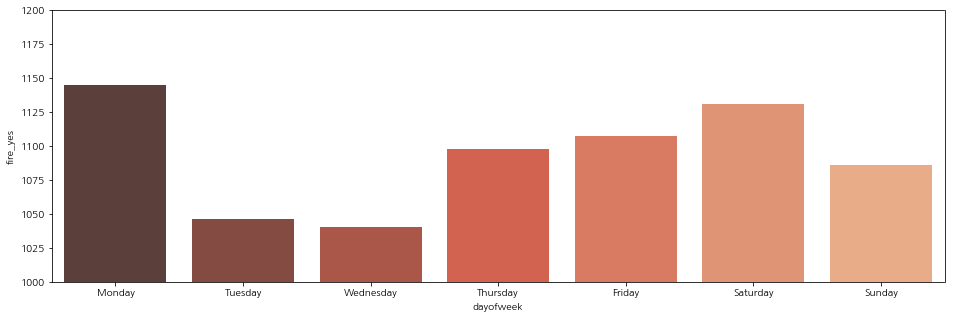

In [14]:
# 요일별 트렌드 확대
plt.figure(figsize=[16, 5])
axes=sns.barplot(x='dayofweek', y='fire_yes', data=data, order=index_weekday, palette='OrRd_d')
axes.set(ylim=(1000, 1200))
plt.show()

# *****요일 - 장소 상관성 확인

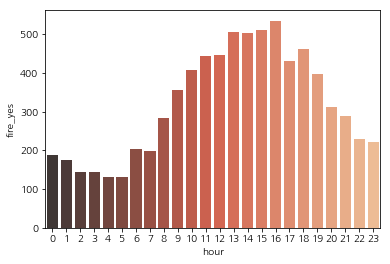

In [15]:
# 시간대별 트렌드
data = pd.DataFrame(train.groupby('hour')['fire_yes'].sum()).reset_index()

sns.barplot(x='hour', y='fire_yes', data=data, palette='OrRd_d')
plt.show()

심야시간 대비 사람들이 활동할 시간에 화재발생 많다

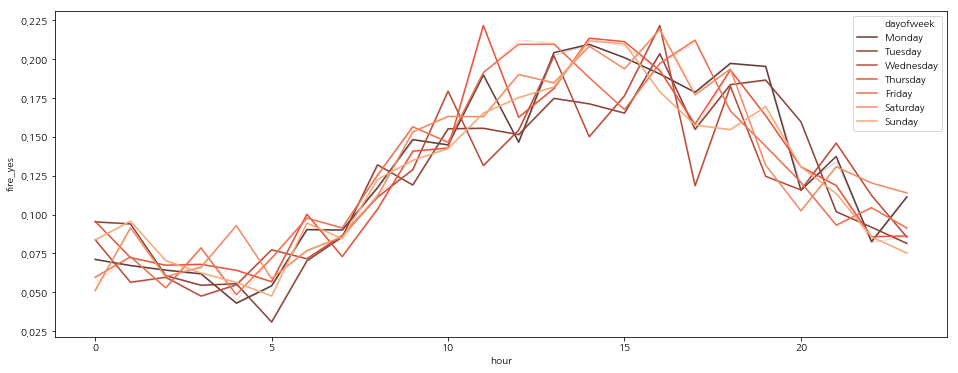

In [16]:
## 요일 시간대 상관성- 딱히 없어보임
plt.figure(figsize=[16, 6])
sns.lineplot(x='hour', y='fire_yes', hue='dayofweek', hue_order=index_weekday, data=train, palette='OrRd_d', ci=False)

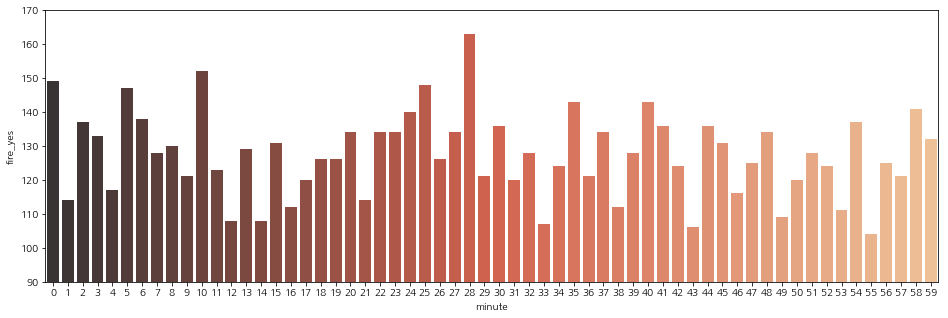

In [17]:
data = pd.DataFrame(train.groupby('minute')['fire_yes'].sum()).reset_index()

plt.figure(figsize=[16, 5])
axes = sns.barplot(x='minute', y='fire_yes', data=data, palette='OrRd_d')
axes.set(ylim=(90, 170))
plt.show()

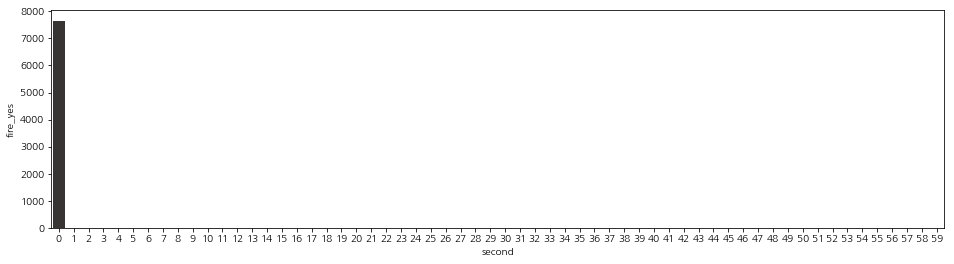

In [18]:
data = pd.DataFrame(train.groupby('second')['fire_yes'].sum()).reset_index()

plt.figure(figsize=[16, 4])
sns.barplot(x='second', y='fire_yes', data=data, palette='OrRd_d')
plt.show()

화재발생 초는 00초로 통일한것으로 보임-의미없음

## df['fire_yes'] == False 불이 안난 날

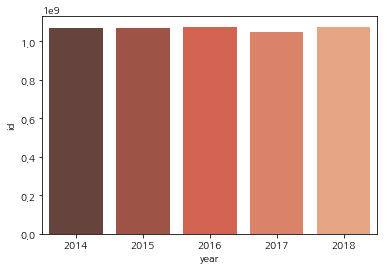

In [19]:
data = pd.DataFrame(train[train['fire_yes'] == False].groupby('year')['id'].sum()).reset_index()

sns.barplot(x='year', y='id', data=data, palette='OrRd_d')

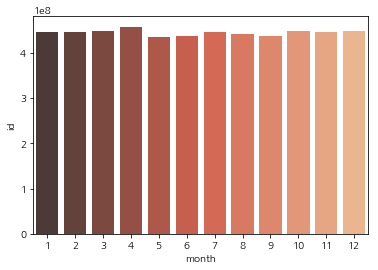

In [20]:
data = pd.DataFrame(train[train['fire_yes'] == False].groupby('month')['id'].sum()).reset_index()

sns.barplot(x='month', y='id', data=data, palette='OrRd_d')

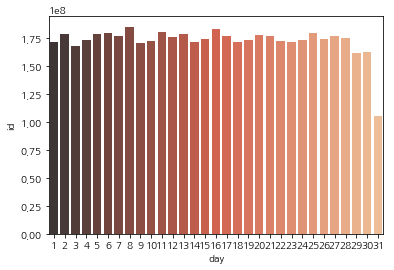

In [21]:
data = pd.DataFrame(train[train['fire_yes'] == False].groupby('day')['id'].sum()).reset_index()

sns.barplot(x='day', y='id', data=data, palette='OrRd_d')

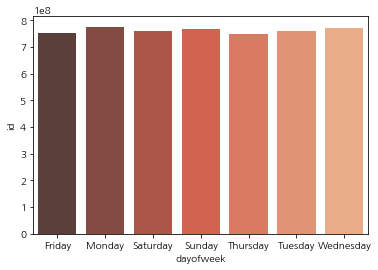

In [22]:
data = pd.DataFrame(train[train['fire_yes'] == False].groupby('dayofweek')['id'].sum()).reset_index()

sns.barplot(x='dayofweek', y='id', data=data, palette='OrRd_d')

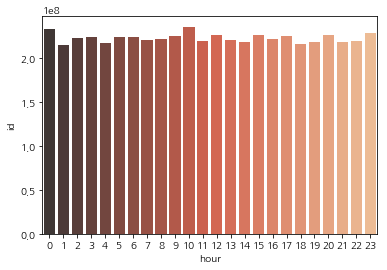

In [23]:
data = pd.DataFrame(train[train['fire_yes'] == False].groupby('hour')['id'].sum()).reset_index()

sns.barplot(x='hour', y='id', data=data, palette='OrRd_d')

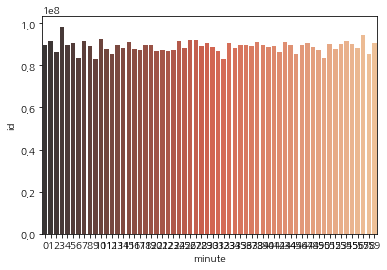

In [24]:
data = pd.DataFrame(train[train['fire_yes'] == False].groupby('minute')['id'].sum()).reset_index()

sns.barplot(x='minute', y='id', data=data, palette='OrRd_d')

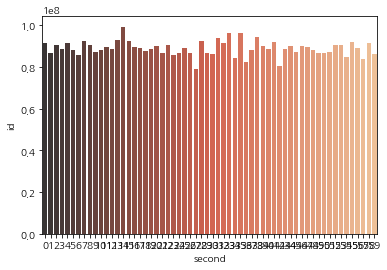

In [25]:
data = pd.DataFrame(train[train['fire_yes'] == False].groupby('second')['id'].sum()).reset_index()

sns.barplot(x='second', y='id', data=data, palette='OrRd_d')

## fr_wthr_fclt_dstnc 소방용수시설과의 최소 거리

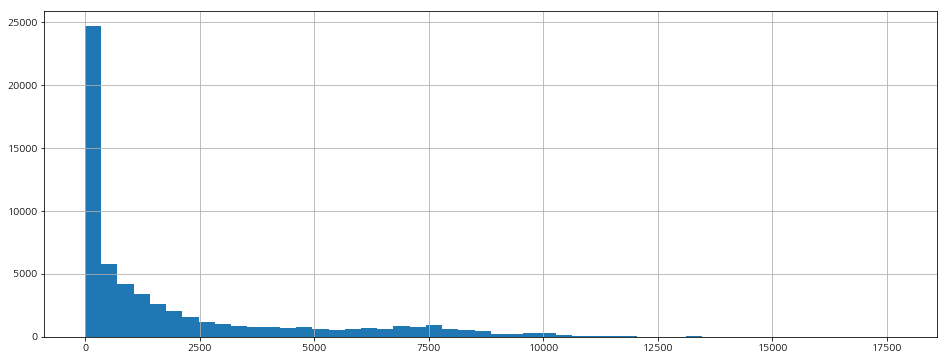

In [26]:
train['fr_wthr_fclt_dstnc'].hist(figsize=[16, 6], bins=50)

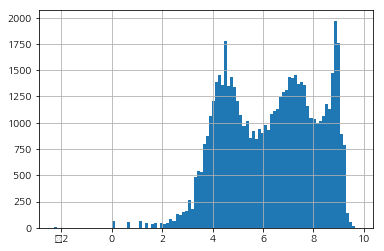

In [27]:
# log scale 적용
train['fr_wthr_fclt_dstnc(log)'] = train['fr_wthr_fclt_dstnc'].apply(lambda x: np.log(x))
train.loc[train['fr_wthr_fclt_dstnc'] == 0, 'fr_wthr_fclt_dstnc(log)'] = np.log(0.1)

train['fr_wthr_fclt_dstnc(log)'].hist(bins=100)

<Figure size 1152x720 with 0 Axes>

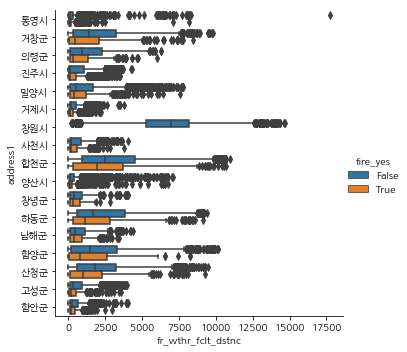

In [29]:
plt.figure(figsize=[16, 10])

sns.catplot(x='fr_wthr_fclt_dstnc', y='address1', hue='fire_yes', data=train, kind='box')
plt.show()

In [33]:
train[train['address1'] == '창원시']['fire_yes'].value_counts()

False    8442
Name: fire_yes, dtype: int64

창원시가 눈에 띄게 소방용수시설과의 거리가 멀다
- 화재발생여부 컬럼을 찾아보니, 화재발생건이 0건이다
- 그래서 소방용수시설과 가까울수록 화재발생이 많다는 상관관계가 보였던 것

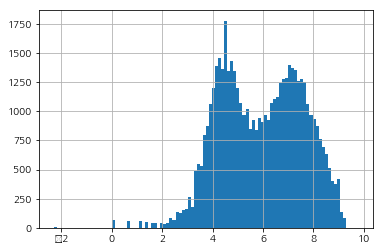

In [31]:
# 창원시 제외
train[train['address1'] != '창원시']['fr_wthr_fclt_dstnc(log)'].hist(bins=100)

창원시를 제외했더니 9 근처에 있던 뾰족한 데이터가 사라짐

train 데이터에서 창원시 제외

In [32]:
train = train[train['address1'] != '창원시']

## fr_wthr_fclt_in_100m 반경 100m 내 소방용수시설 수
- 100m 내 소방용수시설이 많을수록 화재발생
- 불이 많이 나는 곳일수록 소방용수시설 많이 설치?
- 대부분 없다

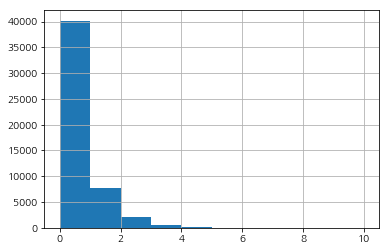

In [34]:
#100m 내 소방용수시설수 전체

train['fr_wthr_fclt_in_100m'].hist()

In [35]:
# 100m 내 소방용수시설수 화재발생건 only

data = pd.DataFrame(train.groupby('fr_wthr_fclt_in_100m')['fire_yes'].sum())
data
# data['fire_yes'].hist(bins=50)

fire_yes
fr_wthr_fclt_in_100m          
0                       5537.0
1                       1447.0
2                        485.0
3                        124.0
4                         45.0
5                         11.0
6                          2.0
7                          2.0
8                          0.0
10                         0.0

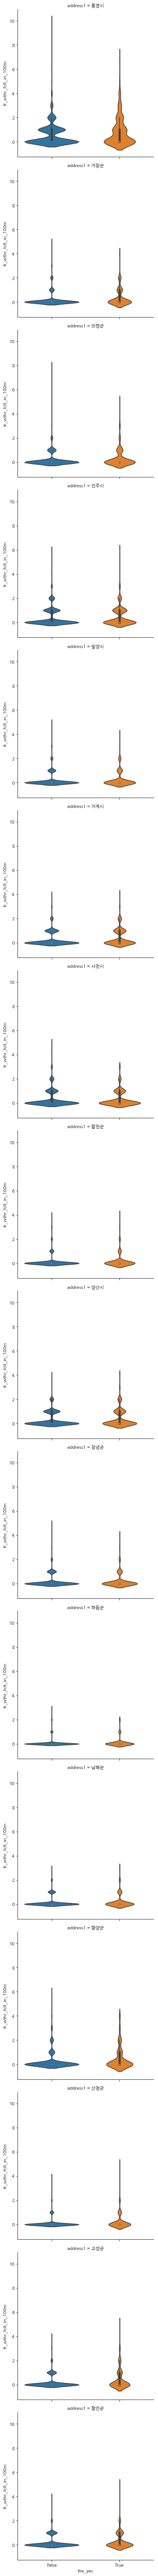

In [36]:
sns.catplot(y='fr_wthr_fclt_in_100m', row='address1', kind='violin', x='fire_yes', data=train)

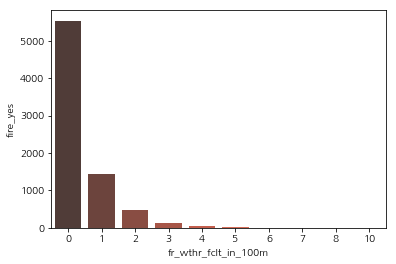

In [37]:
data = pd.DataFrame(train.groupby('fr_wthr_fclt_in_100m')['fire_yes'].sum()).reset_index()

sns.barplot(x='fr_wthr_fclt_in_100m', y='fire_yes', data=data, palette='OrRd_d')

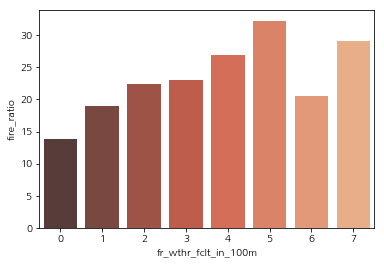

In [38]:
# 소방용수 시설 거리에 따른 화재발생 비율

data_True = pd.DataFrame(train[train['fire_yes'] == True].groupby(['fr_wthr_fclt_in_100m', 'fire_yes'])['id'].sum()).reset_index()
data_False = pd.DataFrame(train[train['fire_yes'] == False].groupby(['fr_wthr_fclt_in_100m', 'fire_yes'])['id'].sum()).reset_index()

data = data_True.merge(data_False, how='inner', on='fr_wthr_fclt_in_100m')
data['fire_ratio'] = data['id_x'].apply(lambda x: int(x)) * 100 / (data['id_x'].apply(lambda x: int(x)) + data['id_y'].apply(lambda x: int(x)))

# data
sns.barplot(x='fr_wthr_fclt_in_100m', y='fire_ratio', data=data, palette='OrRd_d')

## ahsm_dstnc 자동심장충격기와의 거리 
상관없을것 같은데, 외진 곳일수록 자동심장충격기도 적어서 결국 외진 곳에서 화재발생 많이 난다는 뜻?

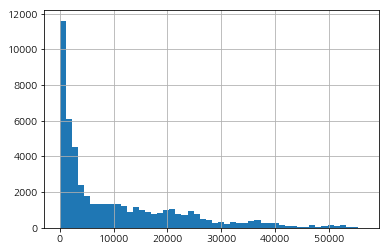

In [39]:
train['ahsm_dstnc'].hist(bins=50)

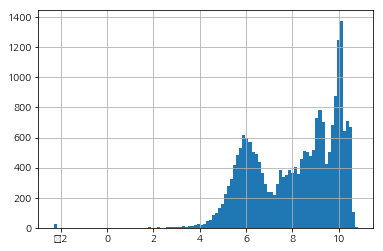

In [97]:
# log scale 적용
train['ahsm_dstnc(log)'] = train['ahsm_dstnc'].apply(lambda x: np.log(x))
train.loc[train['ahsm_dstnc'] == 0, 'ahsm_dstnc(log)'] = np.log(0.1)

train['ahsm_dstnc(log)'].hist(bins=100)

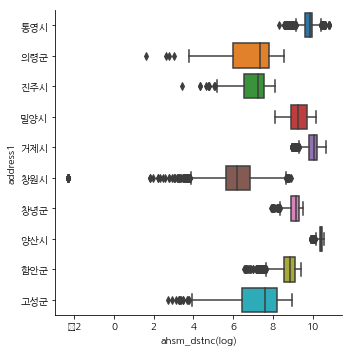

In [98]:
sns.catplot(y='address1', x='ahsm_dstnc(log)', data=train, kind='box')
plt.show()

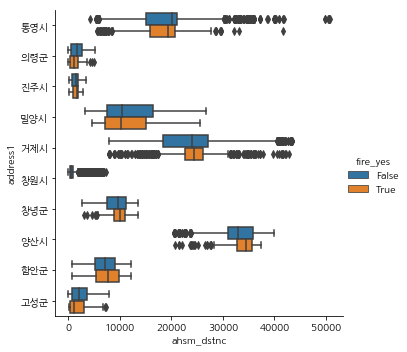

In [99]:
sns.catplot(y='address1', x='ahsm_dstnc', data=train, hue='fire_yes', kind='box')
plt.show()

화재발생여부 보다 지역간 편차가 크다

## jmk 용도

In [43]:
train['jmk'].unique()

array(['대', '주', '잡', '종', '차', '답', '장', '양', '전', '창', '학', '목', '도',
       '임', '철', '유', '천', '구', '체', '과', '묘', '공', '원', '사', '제', '수'],
      dtype=object)

### train 데이터 전체의 jmk 분포

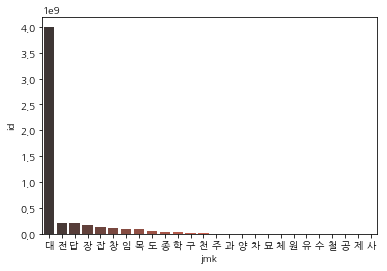

In [44]:
all_jmk = pd.DataFrame(train.groupby('jmk')['id'].sum()).reset_index()
all_jmk = all_jmk.sort_values('id', ascending=False)
columns = all_jmk['jmk']
sns.barplot(x='jmk', y='id', data=all_jmk, palette='OrRd_d')

### jmk 별 화재발생 건수

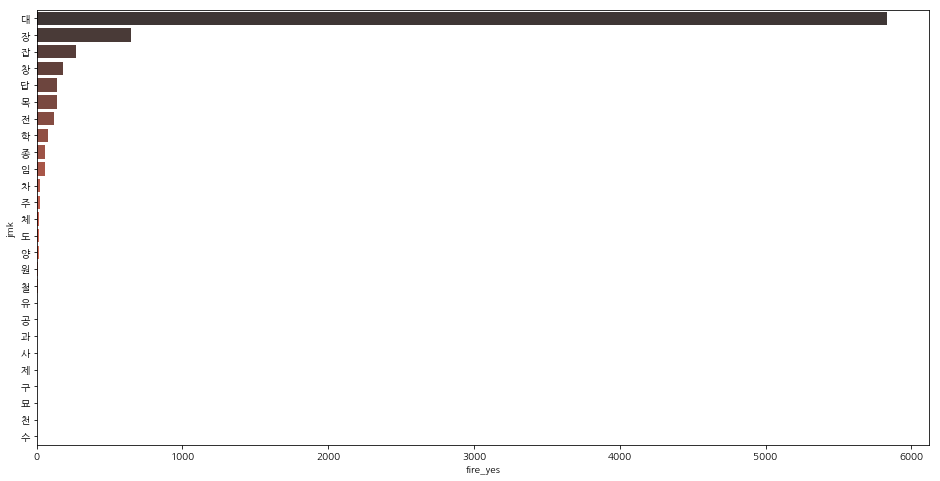

In [45]:
fire_jmk = pd.DataFrame(train.groupby('jmk')['fire_yes'].sum()).reset_index()
fire_jmk = fire_jmk.sort_values(['fire_yes'], ascending=False)

plt.figure(figsize=[16, 8])
sns.barplot(y='jmk', x='fire_yes', data=fire_jmk, palette='OrRd_d')

### jmk 별 화재발생 수 log-scale 

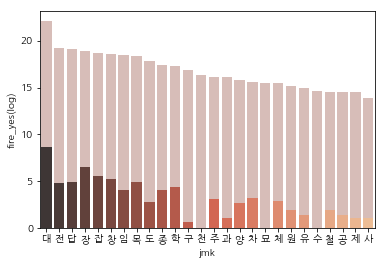

In [48]:
all_jmk['id(log)'] = all_jmk['id'].apply(lambda x: np.log(x))
fire_jmk['fire_yes(log)'] = fire_jmk['fire_yes'].apply(lambda x: np.log(x))

sns.barplot(x='jmk', y='id(log)', data=all_jmk, color='#DCBAB3')
sns.barplot(x='jmk', y='fire_yes(log)', order=columns, data=fire_jmk, palette='OrRd_d')

### 각 지목jmk별 화재발생 비율 계산 

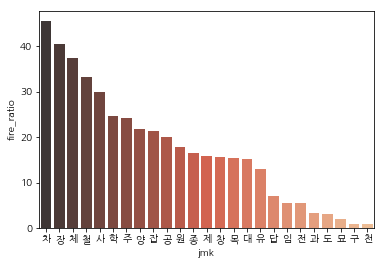

In [49]:
data_True = pd.DataFrame(train[train['fire_yes'] == True].groupby(['jmk', 'fire_yes'])['id'].size()).reset_index()
data_False = pd.DataFrame(train[train['fire_yes'] == False].groupby(['jmk', 'fire_yes'])['id'].size()).reset_index()

data = data_True.merge(data_False, how='left', on='jmk')
data['fire_ratio'] = data['id_x'].apply(lambda x: int(x)) * 100 / (data['id_x'].apply(lambda x: int(x)) + data['id_y'].apply(lambda x: int(x)))

data = data.sort_values('fire_ratio', ascending=False)
data[['jmk', 'fire_ratio']]

sns.barplot(x='jmk', y='fire_ratio', data=data, palette='OrRd_d')

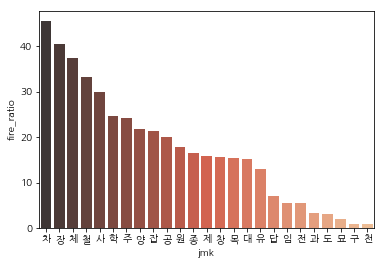

In [50]:
data_True = pd.DataFrame(train[train['fire_yes'] == True].groupby(['jmk', 'fire_yes'])['id'].size()).reset_index()
data_False = pd.DataFrame(train[train['fire_yes'] == False].groupby(['jmk', 'fire_yes'])['id'].size()).reset_index()

data = data_True.merge(data_False, how='left', on=['jmk'])
data['fire_ratio'] = data['id_x'].apply(lambda x: int(x)) * 100 / (data['id_x'].apply(lambda x: int(x)) + data['id_y'].apply(lambda x: int(x)))

data = data.sort_values('fire_ratio', ascending=False)
data[['jmk', 'fire_ratio']]

sns.barplot(x='jmk', y='fire_ratio', data=data, palette='OrRd_d')

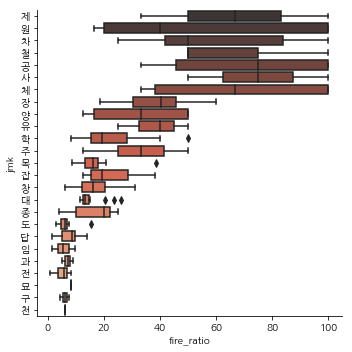

In [51]:
data_True = pd.DataFrame(train[train['fire_yes'] == True].groupby(['address1', 'jmk', 'fire_yes'])['id'].size()).reset_index()
data_False = pd.DataFrame(train[train['fire_yes'] == False].groupby(['address1', 'jmk', 'fire_yes'])['id'].size()).reset_index()

data = data_True.merge(data_False, how='left', on=['address1', 'jmk'])
# Null 값 채우기
data['fire_yes_y'] = data['fire_yes_y'].fillna(False)
data['id_y'] = data['id_y'].fillna(0)

data['fire_ratio'] = data['id_x'].apply(lambda x: int(x)) * 100 / (data['id_x'].apply(lambda x: int(x)) + data['id_y'].apply(lambda x: int(x)))

data = data.sort_values('fire_ratio', ascending=False)
# data[['address1', 'jmk', 'fire_ratio']]

sns.catplot(y='jmk', x='fire_ratio', data=data, kind='box', palette='OrRd_d')

In [37]:
df['fire_yes']

KeyError: 'fire_yes'

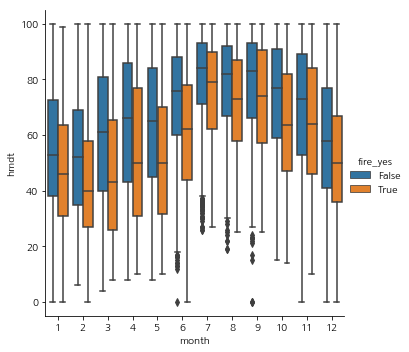

In [46]:
sns.catplot(y='hmdt', x='month', hue='fire_yes', kind='box', data=train)

### 지역별 jmk

In [52]:
# 지역별 jmk 그룹바이
jmk_address1 = pd.DataFrame(train.groupby(['address1', 'jmk'])['id'].size().reset_index())
jmk_address1['id(log)'] = jmk_address1['id'].apply(lambda x: np.log(x))
# jmk 항목 리스트
jmk = train['jmk'].unique()

# 데이터 없는 jmk 행 id(합계) 0 으로 추가
for where in list(jmk_address1['address1'].unique()):
    for x in jmk:
        if x not in jmk_address1[jmk_address1['address1'] == where]['jmk']: 
            jmk_address1 = jmk_address1.append({'address1':where, 'jmk':x, 'id':0, 'id(log)':0}, ignore_index=True)

# 그룹별 합치기
data = pd.DataFrame(jmk_address1.groupby(['address1', 'jmk'])['id'].sum().reset_index())
data['id(log)'] = data['id'].apply(lambda x: np.log(x) if x != 0 else 0)

data

address1 jmk    id   id(log)
0        거제시   공     3  1.098612
1        거제시   과     2  0.693147
2        거제시   구    12  2.484907
3        거제시   답   127  4.844187
4        거제시   대  2938  7.985484
5        거제시   도    27  3.295837
6        거제시   목    13  2.564949
7        거제시   묘     1  0.000000
8        거제시   사     0  0.000000
9        거제시   수     2  0.693147
10       거제시   양    18  2.890372
11       거제시   원     5  1.609438
12       거제시   유     4  1.386294
13       거제시   임    67  4.204693
14       거제시   잡    84  4.430817
15       거제시   장    51  3.931826
16       거제시   전   106  4.663439
17       거제시   제     0  0.000000
18       거제시   종    30  3.401197
19       거제시   주     5  1.609438
20       거제시   차     1  0.000000
21       거제시   창    42  3.737670
22       거제시   천     2  0.693147
23       거제시   철     0  0.000000
24       거제시   체     4  1.386294
25       거제시   학    25  3.218876
26       거창군   공     1  0.000000
27       거창군   과    22  3.091042
28       거창군   구    18  2.890372
29       거창군   답   110  4.700480
..       ...  ..   ...       ...
386      함양군   천     5  1.609438
387      함양군   철     0  0.000000
388      함양군   체     1  0.000000
389      함양군   학    19  2.944439
390      합천군   공     0  0.000000
391      합천군   과     1  0.000000
392      합천군   구    22  3.091042
393      합천군   답   183  5.209486
394      합천군   대  2372  7.771489
395      합천군   도    48  3.871201
396      합천군   목   108  4.682131
397      합천군   묘     2  0.693147
398      합천군   사     0  0.000000
399      합천군   수     1  0.000000
400      합천군   양     0  0.000000
401      합천군   원     5  1.609438
402      합천군   유     5  1.609438
403      합천군   임    85  4.442651
404      합천군   잡    91  4.510860
405      합천군   장    31  3.433987
406      합천군   전   190  5.247024
407      합천군   제     1  0.000000
408      합천군   종    18  2.890372
409      합천군   주     8  2.079442
410      합천군   차     1  0.000000
411      합천군   창    64  4.158883
412      합천군   천    14  2.639057
413      합천군   철     0  0.000000
414      합천군   체     1  0.000000
415      합천군   학    20  2.995732

[416 rows x 4 columns]

In [53]:
# sns.lineplot(x='jmk', y='id(log)', hue='address1', data=jmk_address1)
# plt.legend(loc=[1, 0])

px.line(data, x='jmk', y='id(log)', color='address1')

In [54]:
# 몇 개 행정구역만 따로 보기

# data = jmk_address1[jmk_address1['address1'] == '고성군']

for x in ['거창군', '남해군', '산청군', '통영시']:
    data = pd.concat([data, jmk_address1[jmk_address1['address1'] == x]])
data['address1'].unique()

# sns.lineplot(x='jmk', y='id(log)', hue='address1', data=data)
# plt.legend(loc=[1, 0])
px.line(data, x='jmk', y='id', log_y=True, color='address1')

## fr_sttn_dstnc

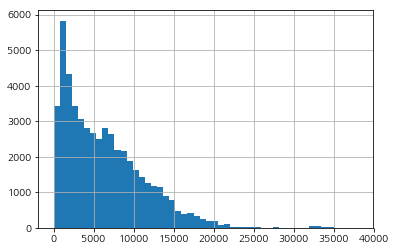

In [55]:
train['fr_sttn_dstnc'].hist(bins=50)

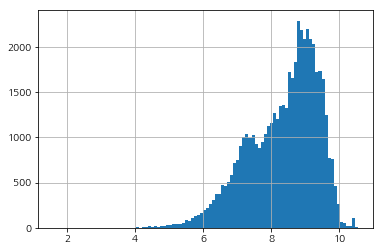

In [56]:
train['fr_sttn_dstnc(log)'] = train['fr_sttn_dstnc'].apply(lambda x: np.log(x))

train['fr_sttn_dstnc(log)'].hist(bins=100)

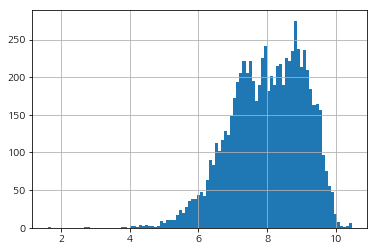

In [57]:
train[train['fire_yes'] == True]['fr_sttn_dstnc(log)'].hist(bins=100)

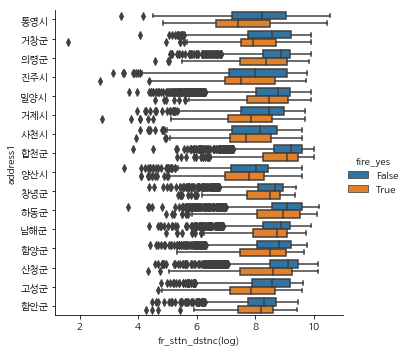

In [58]:
sns.catplot(y='address1', x='fr_sttn_dstnc(log)', hue='fire_yes', kind='box', data=train)

119소방센터와의 거리가 더 가까울수록 화재발생건수가 많다
- 큰 차이를 보이지는 않지만, 전 지역에 동일하게 나타난다

## tbc_rtl_str_dstnc 담배소매점과의 거리

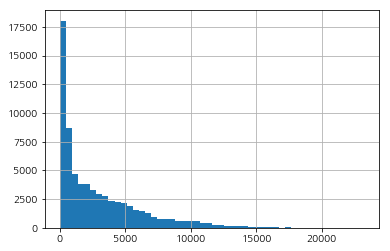

In [59]:
df['tbc_rtl_str_dstnc'].hist(bins=50)

### tbc_rtl_str_dstnc 담배소매점과의 거리 log scale

In [60]:
train['tbc_rtl_str_dstnc(log)'] = np.log(train['tbc_rtl_str_dstnc'])
# 담배 소매점과의 거리가 0 인 곳이 80여곳 있어서, log 값을 그래프에 나타내기 위해 0.1로 고쳐줌
train.loc[train['tbc_rtl_str_dstnc'] == 0, 'tbc_rtl_str_dstnc(log)'] = 0.1
train[['tbc_rtl_str_dstnc', 'tbc_rtl_str_dstnc(log)']].sample()

tbc_rtl_str_dstnc  tbc_rtl_str_dstnc(log)
48087               8541                9.052633

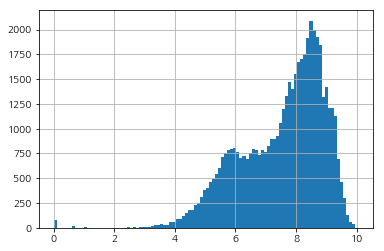

In [61]:
train['tbc_rtl_str_dstnc(log)'].hist(bins=100)

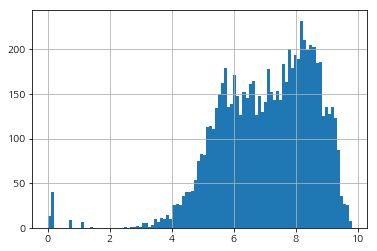

In [62]:
train[train['fire_yes'] == True]['tbc_rtl_str_dstnc(log)'].hist(bins=100)

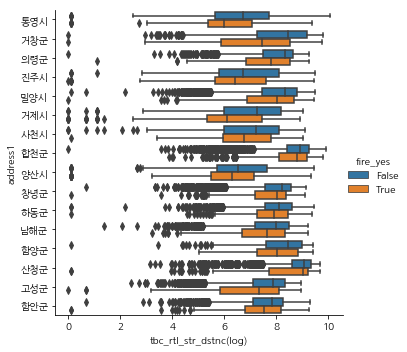

In [63]:
sns.catplot(y='address1', x='tbc_rtl_str_dstnc(log)', hue='fire_yes', kind='box', data=train)

담배소매점과의 거리가 더 가까울수록 화재발생건수가 많다
- 큰 차이를 보이지는 않지만, 전 지역에 동일하게 나타난다

## 행정구역별 화재발생건수

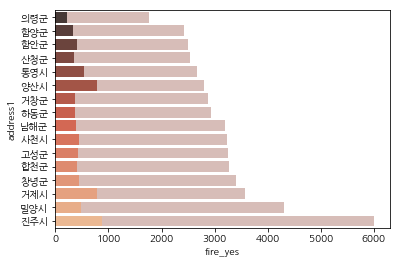

In [64]:
all_address1 = pd.DataFrame(train.groupby('address1')['id'].size().reset_index())
all_address1 = all_address1.sort_values('id')
fire_address1 = pd.DataFrame(train.groupby('address1')['fire_yes'].sum().reset_index())

sns.barplot(y='address1', x='id', data=all_address1, color='#DCBAB3')
sns.barplot(y='address1', x='fire_yes', order = all_address1['address1'], data=fire_address1, palette='OrRd_d')

창원시는 화재발생 데이터 0건
- 창원시 전체를 제외하는 게 좋을 듯

## hm_cnt 행정구역 인구

In [65]:
df[df['address'] == '양산시 물금읍'][['year', 'hm_cnt']].sort_values('year')

year    hm_cnt
4658   2014   59750.0
4435   2014   53752.0
4433   2014   53752.0
4423   2014   60524.0
4422   2014   60524.0
4421   2014   60524.0
4419   2014   60524.0
4416   2014   60524.0
25510  2014   62134.0
25580  2014   55563.0
30001  2014   63879.0
30002  2014   62134.0
4399   2014   57467.0
4398   2014   57467.0
4396   2014   57467.0
4395   2014   57467.0
4394   2014   57467.0
4392   2014   57467.0
5472   2014   60642.0
5282   2014   58972.0
4436   2014   53752.0
5145   2014   52845.0
4576   2014   58972.0
4574   2014   58972.0
4505   2014   54297.0
4504   2014   54297.0
4503   2014   55563.0
4500   2014   55563.0
4499   2014   55563.0
4498   2014   55563.0
...     ...       ...
5104   2018  107957.0
4602   2018  114420.0
4601   2018  114420.0
4600   2018  114420.0
5232   2018  112693.0
5499   2018  114420.0
5580   2018  105892.0
6960   2018  109165.0
6988   2018  109165.0
7051   2018  110372.0
4655   2018  105892.0
4532   2018  115081.0
4530   2018  115081.0
4407   2018  111979.0
4528   2018  115081.0
4486   2018  109165.0
4485   2018  109165.0
4480   2018  113236.0
4479   2018  113236.0
4476   2018  113236.0
4474   2018  113236.0
4472   2018  113236.0
4471   2018  113236.0
4432   2018  106842.0
25577  2018  111979.0
4413   2018  111181.0
4412   2018  111181.0
4410   2018  111181.0
4487   2018  109165.0
4654   2018  105892.0

[367 rows x 2 columns]

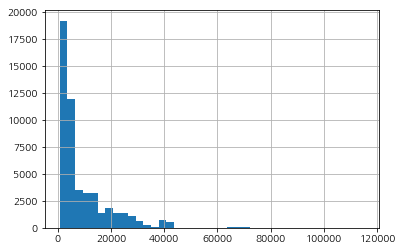

In [66]:
train['hm_cnt'].hist(bins=40)

### 행정구역 인구별 전체 데이터 수(log-scale)

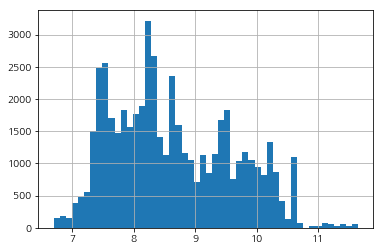

In [67]:
np.log(train['hm_cnt']).hist(bins=50)

### 행정구역 인구별 화재발생 수(log-scale)

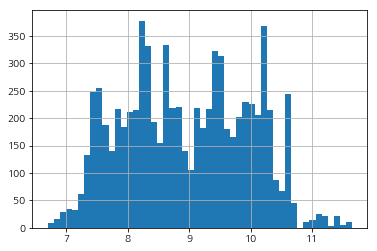

In [68]:
np.log(train[train['fire_yes'] == True]['hm_cnt']).hist(bins=50)

인구가 많은 곳이 상대적으로 화재발생률이 높다

### mlt_us_yn 다중이용시설 포함여부

In [69]:
train['mlt_us_yn(encode)'].unique()

array([False,  True])

In [70]:
fire_mlt_us_yn = pd.DataFrame(train.groupby('mlt_us_yn(encode)')['fire_yes'].sum()).reset_index()
all_mlt_us_yn = pd.DataFrame(train.groupby('mlt_us_yn(encode)')['id'].count()).reset_index()
data = fire_mlt_us_yn.merge(all_mlt_us_yn, on='mlt_us_yn(encode)')
data['ratio'] = data['fire_yes'] * 100 / data['id']
data

mlt_us_yn(encode)  fire_yes     id      ratio
0              False    7544.0  50567  14.918821
1               True     109.0    182  59.890110

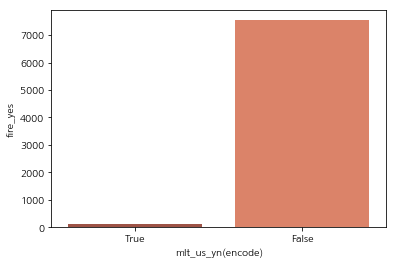

In [71]:
# train 데이터 전체 다중이용시설 포함여부
sns.barplot(x='mlt_us_yn(encode)', y='fire_yes',order=[True, False], data=data, palette='OrRd_d')

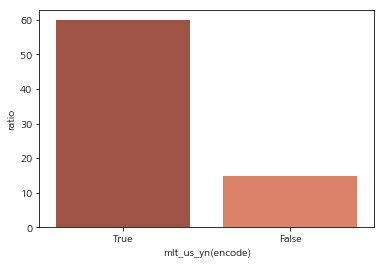

In [72]:
# 다중이용시설 포함여부별 화재발생 비율
sns.barplot(x='mlt_us_yn(encode)', y='ratio', order=[True, False], data=data, palette='OrRd_d')

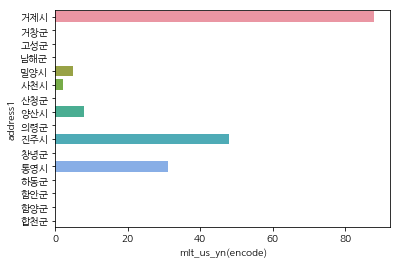

In [73]:
data = pd.DataFrame(train.groupby('address1')['mlt_us_yn(encode)'].sum().reset_index())
sns.barplot(y='address1', x='mlt_us_yn(encode)', data=data)

## fr_mn_cnt 관할소방서 인원

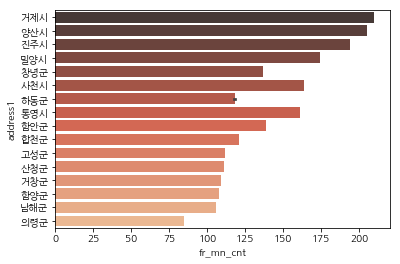

In [74]:
fr_mn_cnt = train.sort_values('fr_mn_cnt', ascending=False)

sns.barplot(y='address1', x='fr_mn_cnt', data=fr_mn_cnt, palette='OrRd_d')

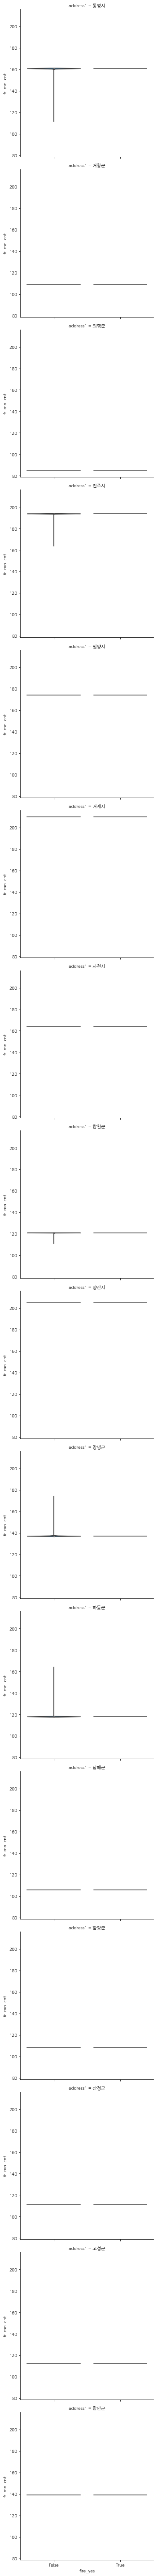

In [75]:
sns.catplot(row='address1', y='fr_mn_cnt', x='fire_yes', kind='violin', data=train)

In [76]:
train.columns

Index(['id', 'tag', 'year', 'month', 'day', 'dayofweek', 'year-month',
       'year-month-day', 'hour', 'minute', 'second', 'jmk',
       'mlt_us_yn(encode)', 'tmprtr', 'wnd_spd', 'wnd_drctn', 'hmdt',
       'address', 'address1', 'address2', 'hm_cnt', 'fr_sttn_dstnc',
       'fr_wthr_fclt_dstnc', 'cctv_dstnc', 'cctv_in_100m', 'fr_mn_cnt',
       'fr_wthr_fclt_in_100m', 'tbc_rtl_str_dstnc', 'sft_emrgnc_bll_dstnc',
       'ahsm_dstnc', 'no_tbc_zn_dstnc', 'bldng_cnt_in_50m', 'fire_yes',
       'fr_wthr_fclt_dstnc(log)', 'ahsm_dstnc(log)', 'fr_sttn_dstnc(log)',
       'tbc_rtl_str_dstnc(log)'],
      dtype='object')

## 지역 특성 PCA 한 데이터에 더미코딩 컬럼 합치기

In [209]:
train_PCA = pd.read_csv('../Data/train_PCA.csv')
test_PCA = pd.read_csv('../Data/test_PCA.csv')
valid_PCA = pd.read_csv('../Data/valid_PCA.csv')

In [211]:
df_PCA = pd.concat([train_PCA, test_PCA, valid_PCA])

In [214]:
df_PCA.shape

(69046, 41)

In [215]:
df = df_PCA

# 추가 전처리
- jmk 더미코딩
- 전기 가스 사용량

In [216]:
jmk = df['jmk'].unique()

for x in jmk[1:]: 
    df[f'jmk_{x}'] = df['jmk'] == f'{x}'
df.sample()

index  address address1 address2  ahsm_dstnc  bldng_ar  bldng_cnt  \
39080  39080  하동군 양보면      하동군      양보면        1979      11.9          2   

       bldng_cnt_in_50m  cctv_dstnc  cctv_in_100m  ...  jmk_천  jmk_구  jmk_체  \
39080                 0        7633             0  ...  False  False  False   

       jmk_과  jmk_묘  jmk_공  jmk_원  jmk_사  jmk_제  jmk_수  
39080  False  False  False  False  False  False  False  

[1 rows x 66 columns]

In [217]:
train_row = pd.read_csv('../Data/PJT002_train.csv')
test_row = pd.read_csv('../Data/PJT002_test.csv')
valid_row = pd.read_csv('../Data/PJT002_validation.csv')

In [218]:
df_row = pd.concat([train_row, test_row, valid_row])

## lnd_us_sttn_nm 토지 이용상황명

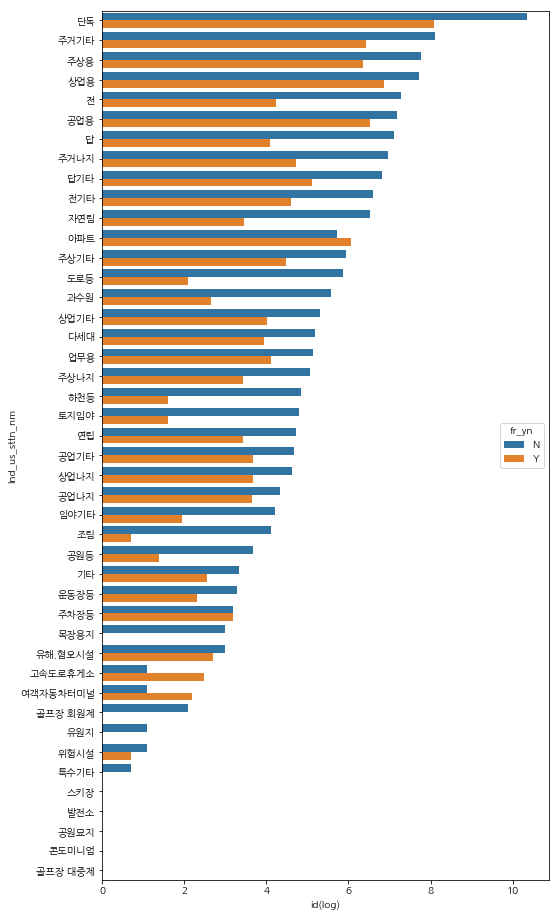

In [219]:
data = pd.DataFrame(train_row.groupby(['lnd_us_sttn_nm', 'fr_yn'])['id'].size().reset_index())
data = data.sort_values('id', ascending=False)
data['id(log)'] = data['id'].apply(lambda x: np.log(x))

data

plt.figure(figsize=[8, 16])
sns.barplot(x='id(log)', y='lnd_us_sttn_nm', hue='fr_yn', data=data)

In [220]:
df_row['lnd_us_sttn_nm'].isnull().sum()
test_row['lnd_us_sttn_nm'].isnull().sum()

75

In [221]:
df_row['jmk'].isnull().sum()

0

In [222]:
lnd_mode = df_row.groupby('jmk')['lnd_us_sttn_nm'].apply(lambda x: x.mode())
lnd_mode['공'][0]
# df_row[df_row['jmk'] == '제']['lnd_us_sttn_nm']

'공원등'

In [223]:
lnd_mode = pd.DataFrame(lnd_mode.reset_index())
data = lnd_mode.drop(18)
data = data.drop('level_1', axis=1)

data['lnd_mode'] = data['lnd_us_sttn_nm']

In [224]:
data

jmk lnd_us_sttn_nm lnd_mode
0    공            공원등      공원등
1    과            과수원      과수원
2    구            하천등      하천등
3    답              답        답
4    대             단독       단독
5    도            도로등      도로등
6    목            답기타      답기타
7    묘            전기타      전기타
8    사            공원등      공원등
9    수            도로등      도로등
10   양           주거기타     주거기타
11   원            상업용      상업용
12   유            하천등      하천등
13   임            자연림      자연림
14   잡           주거기타     주거기타
15   장            공업용      공업용
16   전              전        전
17   제             단독       단독
19   종           주거기타     주거기타
20   주            상업용      상업용
21   차           주차장등     주차장등
22   창           주거기타     주거기타
23   천            하천등      하천등
24   철            도로등      도로등
25   체           운동장등     운동장등
26   학           주거기타     주거기타

In [225]:
df_row = df_row.merge(data[['jmk', 'lnd_mode']] , how='left', on='jmk')
df_row[['lnd_us_sttn_nm', 'lnd_mode']]

# for x in jmk:
#     df_row.loc[df_row['lnd_us_sttn_nm'].isnull(), ]['lnd_us_sttn_nm'].fillna(lnd_mode_clean[f'{x}'])
    
# df_row['lnd_us_sttn_nm(clean)'].isnull().sum()

lnd_us_sttn_nm lnd_mode
0                 단독       단독
1                업무용       단독
2                 단독       단독
3                상업용      상업용
4                 단독       단독
5                아파트       단독
6                주상용       단독
7                 단독       단독
8                 단독       단독
9                 단독       단독
10               주상용       단독
11                단독       단독
12                단독       단독
13                단독       단독
14                단독       단독
15                단독       단독
16                단독       단독
17               아파트       단독
18                단독       단독
19                단독       단독
20                단독       단독
21                단독       단독
22                단독       단독
23                단독       단독
24                단독       단독
25                단독       단독
26                단독       단독
27                단독       단독
28                단독       단독
29              주거기타       단독
...              ...      ...
69024            공업용      공업용
69025             단독       단독
69026            공업용      공업용
69027            공업용      공업용
69028             단독       단독
69029            공업용      공업용
69030            상업용      상업용
69031              답        전
69032            주상용       단독
69033            주상용       단독
69034        골프장 대중제       단독
69035            공업용      공업용
69036           상업기타       단독
69037             단독       단독
69038             단독       단독
69039             단독       단독
69040             단독       단독
69041             단독       단독
69042           주거기타        전
69043            상업용       단독
69044            공업용      공업용
69045           주거기타       단독
69046             단독       단독
69047             단독       단독
69048             단독       단독
69049             단독       단독
69050           주상기타       단독
69051            공업용      공업용
69052            공업용      공업용
69053            상업용       단독

[69054 rows x 2 columns]

In [226]:
df_row['lnd_us_sttn_nm(clean)'] = df_row['lnd_us_sttn_nm']

df_row.loc[df_row['lnd_us_sttn_nm'].isnull(), 'lnd_us_sttn_nm(clean)'] = df_row['lnd_mode']

df_row.sample()

ahsm_dstnc  bldng_ar  bldng_ar_prc bldng_archtctr  bldng_cnt  \
44293         666     64.45      912335.0          일반목구조          4   

       bldng_cnt_in_50m bldng_us bldng_us_clssfctn  cctv_dstnc  cctv_in_100m  \
44293                 9     단독주택               주거용          88             0   

       ... sft_emrgnc_bll_dstnc tbc_rtl_str_dstnc  tmprtr  ttl_ar  \
44293  ...                77857               370    -1.4   64.45   

       ttl_dwn_flr  ttl_grnd_flr  wnd_drctn  wnd_spd  lnd_mode  \
44293          0.0           2.0      250.0      0.9        단독   

       lnd_us_sttn_nm(clean)  
44293                     단독  

[1 rows x 174 columns]

In [227]:
df_row['lnd_us_sttn_nm(clean)'].isnull().sum()

0

In [228]:
df_lnd = df.merge(df_row[['id', 'lnd_us_sttn_nm(clean)']], how='left', on='id')

df_lnd.sample()

index  address address1 address2  ahsm_dstnc   bldng_ar  bldng_cnt  \
5523   5523  양산시 평산동      양산시      평산동       49897  5045.4915         18   

      bldng_cnt_in_50m  cctv_dstnc  cctv_in_100m  ...  jmk_구  jmk_체  jmk_과  \
5523                 1          71             2  ...  False  False  False   

      jmk_묘  jmk_공  jmk_원  jmk_사  jmk_제  jmk_수  lnd_us_sttn_nm(clean)  
5523  False  False  False  False  False  False                    아파트  

[1 rows x 67 columns]

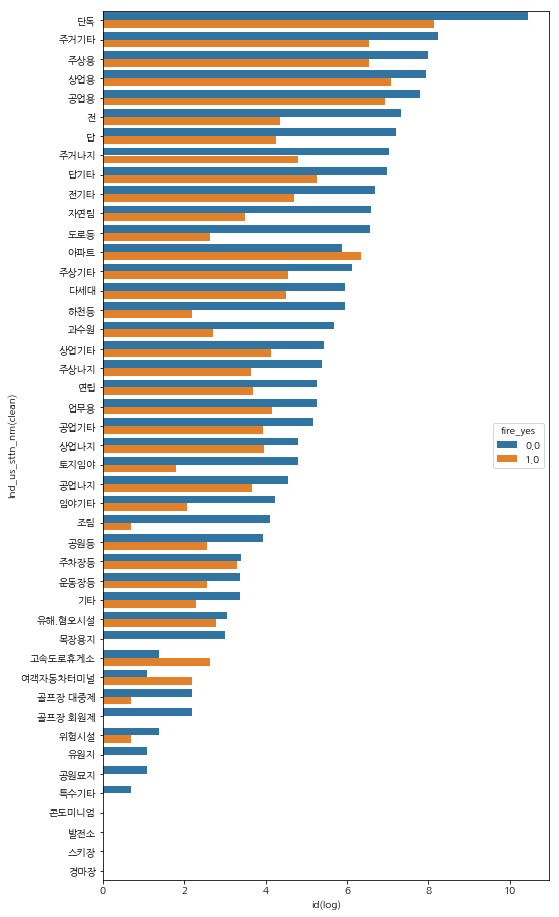

In [229]:
data = pd.DataFrame(df_lnd.groupby(['lnd_us_sttn_nm(clean)', 'fire_yes'])['id'].size().reset_index())
data = data.sort_values('id', ascending=False)
data['id(log)'] = data['id'].apply(lambda x: np.log(x))

data

plt.figure(figsize=[8, 16])
sns.barplot(x='id(log)', y='lnd_us_sttn_nm(clean)', hue='fire_yes', data=data)

### 더미코딩 lnd_us_sttn_nm

In [231]:
df = df_lnd
lnd = df['lnd_us_sttn_nm(clean)'].unique()

for x in jmk[1:]: 
    df[f'lnd_us_sttn_nm_{x}'] = df['lnd_us_sttn_nm(clean)'] == f'{x}'
df.sample()

index  address address1 address2  ahsm_dstnc  bldng_ar  bldng_cnt  \
49491  49491  산청군 삼장면      산청군      삼장면        1591    193.18          2   

       bldng_cnt_in_50m  cctv_dstnc  cctv_in_100m  ...  lnd_us_sttn_nm_천  \
49491                 5         210             0  ...             False   

      lnd_us_sttn_nm_구  lnd_us_sttn_nm_체  lnd_us_sttn_nm_과  lnd_us_sttn_nm_묘  \
49491            False             False             False             False   

       lnd_us_sttn_nm_공  lnd_us_sttn_nm_원  lnd_us_sttn_nm_사  lnd_us_sttn_nm_제  \
49491             False             False             False             False   

       lnd_us_sttn_nm_수  
49491             False  

[1 rows x 92 columns]

In [237]:
df = df.drop('index', axis=1)

## jmk, lnd 추가 전처리 파일 저장

In [238]:
df[df['tag'] == 'train'].to_csv('../Data/train_PCA_jmk_lnd.csv', index=False)
df[df['tag'] == 'test'].to_csv('../Data/test_PCA_jmk_lnd.csv', index=False)
df[df['tag'] == 'valid'].to_csv('../Data/valid_PCA_jmk_lnd.csv', index=False)

In [239]:
pd.read_csv('../Data/train_PCA_jmk_lnd.csv')

address address1 address2  ahsm_dstnc    bldng_ar  bldng_cnt  \
0      통영시 용남면      통영시      용남면       17664    112.8600          3   
1      통영시 용남면      통영시      용남면       18136    721.8200          3   
2      통영시 용남면      통영시      용남면       14944     47.0600          4   
3      통영시 용남면      통영시      용남면       15104    171.4500          2   
4      거창군 북상면      거창군      북상면        5000      0.0000          4   
5      통영시 용남면      통영시      용남면       18462  30351.4800         15   
6      통영시 용남면      통영시      용남면       17388    114.1500          3   
7      통영시 용남면      통영시      용남면       19649     81.2100          3   
8      통영시 용남면      통영시      용남면       17916     61.9500          1   
9      통영시 용남면      통영시      용남면       14479    158.5700          1   
10     통영시 용남면      통영시      용남면       14792    231.6000          1   
11     통영시 용남면      통영시      용남면       14997    128.5000          1   
12     통영시 용남면      통영시      용남면       15757     70.6500          3   
13     통영시 용남면      통영시      용남면       17333     59.1000          2   
14     통영시 용남면      통영시      용남면       19979    204.0000          2   
15     통영시 용남면      통영시      용남면       15693     97.7600          1   
16     통영시 용남면      통영시      용남면       15692     62.4800          2   
17     통영시 용남면      통영시      용남면       15332   1356.2814          6   
18     통영시 용남면      통영시      용남면       18110    100.3500          1   
19     통영시 용남면      통영시      용남면       19651    166.9000          2   
20     통영시 용남면      통영시      용남면       18016     37.0100          2   
21     통영시 용남면      통영시      용남면       17176     34.5800          2   
22     통영시 용남면      통영시      용남면       15342     26.7700          2   
23     통영시 용남면      통영시      용남면       16361     68.6400          1   
24     통영시 용남면      통영시      용남면       15684     23.4000          1   
25     통영시 용남면      통영시      용남면       17310     99.8300          2   
26     통영시 용남면      통영시      용남면       15625     41.1400          1   
27     통영시 용남면      통영시      용남면       19998    171.7200          3   
28     통영시 용남면      통영시      용남면       15303    157.6900          1   
29     통영시 용남면      통영시      용남면       14574    122.5100          1   
...        ...      ...      ...         ...         ...        ...   
59161  통영시 산양읍      통영시      산양읍       25333     58.8400          2   
59162  하동군 횡천면      하동군      횡천면         609    104.7000          8   
59163  통영시 산양읍      통영시      산양읍       25321    323.7700          2   
59164  통영시 산양읍      통영시      산양읍       25156     83.5700          1   
59165  통영시 산양읍      통영시      산양읍       29690     66.9000          1   
59166  통영시 산양읍      통영시      산양읍       24084    200.2300          2   
59167  통영시 산양읍      통영시      산양읍       20671     63.7600          4   
59168  통영시 산양읍      통영시      산양읍       18871      0.0000          2   
59169  통영시 산양읍      통영시      산양읍       20990     40.3300          2   
59170  통영시 용남면      통영시      용남면       15854     19.2000          3   
59171  통영시 용남면      통영시      용남면       14831    261.3900          4   
59172  창녕군 부곡면      창녕군      부곡면        6584     41.9800          6   
59173  통영시 용남면      통영시      용남면       15434    108.6800          1   
59174  통영시 용남면      통영시      용남면       14932   1009.8600          3   
59175  통영시 용남면      통영시      용남면       11823     42.8700          1   
59176  통영시 용남면      통영시      용남면       14058     52.1000          2   
59177  통영시 용남면      통영시      용남면       14640    103.8000          3   
59178  통영시 용남면      통영시      용남면       14199    115.4400          5   
59179  통영시 용남면      통영시      용남면       15818     72.8700          2   
59180  통영시 용남면      통영시      용남면        6195     67.1100          2   
59181  통영시 용남면      통영시      용남면       14752    287.0200          1   
59182  통영시 용남면      통영시      용남면       15895    147.6800          1   
59183  통영시 용남면      통영시      용남면       15672     78.7100          1   
59184  통영시 용남면      통영시      용남면       14439    106.4100          4   
59185  통영시 용남면      통영시      용남

In [2]:
import pandas as pd

In [3]:
train = pd.read_csv('../Data/train_all.csv')
test = pd.read_csv('../Data/test_all.csv')
valid = pd.read_csv('../Data/valid_all.csv')

In [4]:
df = pd.concat([train, test, valid])

In [16]:
pd.DataFrame(df.columns)

0
0                address_x
1               address1_x
2               address2_x
3             ahsm_dstnc_x
4               bldng_ar_x
5             bldng_ar_prc
6           bldng_archtctr
7              bldng_cnt_x
8       bldng_cnt_in_50m_x
9                 bldng_us
10       bldng_us_clssfctn
11            cctv_dstnc_x
12          cctv_in_100m_x
13                   day_x
14             dayofweek_x
15           dt_of_athrztn
16     ele_engry_us_201401
17     ele_engry_us_201402
18     ele_engry_us_201403
19     ele_engry_us_201404
20     ele_engry_us_201405
21     ele_engry_us_201406
22     ele_engry_us_201407
23     ele_engry_us_201408
24     ele_engry_us_201409
25     ele_engry_us_201410
26     ele_engry_us_201411
27     ele_engry_us_201412
28     ele_engry_us_201501
29     ele_engry_us_201502
..                     ...
251                  jmk_수
252  lnd_us_sttn_nm(clean)
253       lnd_us_sttn_nm_주
254       lnd_us_sttn_nm_잡
255       lnd_us_sttn_nm_종
256       lnd_us_sttn_nm_차
257       lnd_us_sttn_nm_답
258       lnd_us_sttn_nm_장
259       lnd_us_sttn_nm_양
260       lnd_us_sttn_nm_전
261       lnd_us_sttn_nm_창
262       lnd_us_sttn_nm_학
263       lnd_us_sttn_nm_목
264       lnd_us_sttn_nm_도
265       lnd_us_sttn_nm_임
266       lnd_us_sttn_nm_철
267       lnd_us_sttn_nm_유
268       lnd_us_sttn_nm_천
269       lnd_us_sttn_nm_구
270       lnd_us_sttn_nm_체
271       lnd_us_sttn_nm_과
272       lnd_us_sttn_nm_묘
273       lnd_us_sttn_nm_공
274       lnd_us_sttn_nm_원
275       lnd_us_sttn_nm_사
276       lnd_us_sttn_nm_제
277       lnd_us_sttn_nm_수
278          ttl_dwn_flr_y
279         ttl_grnd_flr_y
280              prcpttn_y

[281 rows x 1 columns]

In [22]:
df['year-month_y']

0       2015-10
1       2016-11
2       2016-11
3       2016-11
4       2014-01
5       2016-11
6       2016-11
7       2014-01
8       2014-01
9       2014-01
10      2014-01
11      2016-05
12      2015-02
13      2015-02
14      2018-02
15      2018-02
16      2018-02
17      2018-02
18      2018-02
19      2016-07
20      2016-07
21      2016-07
22      2016-07
23      2016-07
24      2016-07
25      2016-07
26      2016-07
27      2018-04
28      2018-04
29      2018-04
         ...   
6868    2016-08
6869    2018-12
6870    2018-08
6871    2015-08
6872    2014-01
6873    2018-12
6874    2016-07
6875    2015-07
6876    2018-11
6877    2015-06
6878    2018-03
6879    2018-08
6880    2016-08
6881    2016-05
6882    2017-06
6883    2018-06
6884    2015-12
6885    2014-03
6886    2018-05
6887    2015-09
6888    2017-04
6889    2014-12
6890    2016-10
6891    2015-05
6892    2016-02
6893    2014-04
6894    2016-09
6895    2016-08
6896    2017-08
6897    2015-09
Name: year-month_y, Leng

## 전기, 가스 사용량 관찰일시에 해당하는 값 넣기
근데 다 NaN 아니면 0임....

In [23]:
for i in df['id']:
    date = list(df[df['id'] == i]['year-month_y'])[0].replace('-', '')[:6]

    df['electricity'] = df[f'ele_engry_us_{date}']
    df['gas'] = df[f'gas_engry_us_{date}']

df[['electricity', 'gas']].sample()

electricity  gas
35014         -1.0 -1.0

In [62]:
# df_energy = df.merge(df_row[['id', 'electricity', 'gas']], how='left', on='id')

# df_energy.sample()

address address1 address2  ahsm_dstnc  bldng_ar  bldng_cnt  \
31704  김해시 대동면      김해시      대동면       30060    108.07          2   

       bldng_cnt_in_50m  cctv_dstnc  cctv_in_100m  day  ...  jmk_학  jmk_철  \
31704                 0         105             0   11  ...  False  False   

       jmk_제  jmk_수  jmk_체  jmk_원  jmk_공  jmk_사  electricity  gas  
31704  False  False  False  False  False  False          NaN  NaN  

[1 rows x 65 columns]

In [63]:
# df_energy['electricity'].isnull().sum()
# df_energy['gas'].isnull().sum()
# df_energy['electricity'].value_counts()
# df_energy['gas'].value_counts()
# df_row['ele_engry_us_201701'].value_counts()

df['electricity'].isnull().sum()
df['gas'].isnull().sum()
df['electricity'].value_counts()
df['gas'].value_counts()
# df['ele_engry_us_201701'].value_counts()

21781

## 전처리한 파일 저장

In [73]:
df[df['tag'] == 'train'].to_csv('../Data/train_all_energy.csv', index=False)
df[df['tag'] == 'test'].to_csv('../Data/test_all_energy.csv', index=False)
df[df['tag'] == 'valid'].to_csv('../Data/valid_all_energy.csv', index=False)

In [74]:
pd.read_csv('../Data/train_3rd_cluster_jmk.csv')

address address1 address2  ahsm_dstnc    bldng_ar  bldng_cnt  \
0      통영시 용남면      통영시      용남면       17664    112.8600          3   
1      통영시 용남면      통영시      용남면       18136    721.8200          3   
2      통영시 용남면      통영시      용남면       14944     47.0600          4   
3      통영시 용남면      통영시      용남면       15104    171.4500          2   
4      통영시 용남면      통영시      용남면       18462  30351.4800         15   
5      통영시 용남면      통영시      용남면       17388    114.1500          3   
6      통영시 용남면      통영시      용남면       19649     81.2100          3   
7      통영시 용남면      통영시      용남면       17916     61.9500          1   
8      통영시 용남면      통영시      용남면       14479    158.5700          1   
9      통영시 용남면      통영시      용남면       14792    231.6000          1   
10     통영시 용남면      통영시      용남면       14997    128.5000          1   
11     통영시 용남면      통영시      용남면       15757     70.6500          3   
12     통영시 용남면      통영시      용남면       17333     59.1000          2   
13     통영시 용남면      통영시      용남면       19979    204.0000          2   
14     통영시 용남면      통영시      용남면       15693     97.7600          1   
15     통영시 용남면      통영시      용남면       15692     62.4800          2   
16     통영시 용남면      통영시      용남면       15332   1356.2814          6   
17     통영시 용남면      통영시      용남면       18110    100.3500          1   
18     통영시 용남면      통영시      용남면       19651    166.9000          2   
19     통영시 용남면      통영시      용남면       18016     37.0100          2   
20     통영시 용남면      통영시      용남면       17176     34.5800          2   
21     통영시 용남면      통영시      용남면       15342     26.7700          2   
22     통영시 용남면      통영시      용남면       16361     68.6400          1   
23     통영시 용남면      통영시      용남면       15684     23.4000          1   
24     통영시 용남면      통영시      용남면       17310     99.8300          2   
25     통영시 용남면      통영시      용남면       15625     41.1400          1   
26     통영시 용남면      통영시      용남면       19998    171.7200          3   
27     통영시 용남면      통영시      용남면       15303    157.6900          1   
28     통영시 용남면      통영시      용남면       14574    122.5100          1   
29     통영시 용남면      통영시      용남면       17509     98.8900          2   
...        ...      ...      ...         ...         ...        ...   
22331  통영시 산양읍      통영시      산양읍       20873      0.0000          1   
22332  통영시 산양읍      통영시      산양읍       25333     58.8400          2   
22333  통영시 산양읍      통영시      산양읍       25321    323.7700          2   
22334  통영시 산양읍      통영시      산양읍       25156     83.5700          1   
22335  통영시 산양읍      통영시      산양읍       29690     66.9000          1   
22336  통영시 산양읍      통영시      산양읍       24084    200.2300          2   
22337  통영시 산양읍      통영시      산양읍       20671     63.7600          4   
22338  통영시 산양읍      통영시      산양읍       18871      0.0000          2   
22339  통영시 산양읍      통영시      산양읍       20990     40.3300          2   
22340  통영시 용남면      통영시      용남면       15854     19.2000          3   
22341  통영시 용남면      통영시      용남면       14831    261.3900          4   
22342  창녕군 부곡면      창녕군      부곡면        6584     41.9800          6   
22343  통영시 용남면      통영시      용남면       15434    108.6800          1   
22344  통영시 용남면      통영시      용남면       14932   1009.8600          3   
22345  통영시 용남면      통영시      용남면       11823     42.8700          1   
22346  통영시 용남면      통영시      용남면       14058     52.1000          2   
22347  통영시 용남면      통영시      용남면       14640    103.8000          3   
22348  통영시 용남면      통영시      용남면       14199    115.4400          5   
22349  통영시 용남면      통영시      용남면       15818     72.8700          2   
22350  통영시 용남면      통영시      용남면        6195     67.1100          2   
22351  통영시 용남면      통영시      용남면       14752    287.0200          1   
22352  통영시 용남면      통영시      용남면       15895    147.6800          1   
22353  통영시 용남면      통영시      용남면       15672     78.7100          1   
22354  통영시 용남면      통영시      용남면       14439    106.4100          4   
22355  통영시 용남면      통영시      용남

In [89]:
data['lnd_us_sttn_nm'].value_counts()

과수원         2
자연림         2
전           2
운동장등        2
고속도로휴게소     2
임야기타        2
답           2
공업나지        2
주상나지        2
연립          2
공원묘지        2
업무용         2
아파트         2
토지임야        2
단독          2
조림          2
상업용         2
주거나지        2
상업나지        2
여객자동차터미널    2
주거기타        2
상업기타        2
답기타         2
목장용지        2
전기타         2
공업기타        2
도로등         2
공업용         2
공원등         2
하천등         2
주차장등        2
다세대         2
주상기타        2
기타          2
주상용         2
위험시설        2
유해.혐오시설     2
골프장 대중제     1
콘도미니엄       1
골프장 회원제     1
발전소         1
특수기타        1
유원지         1
스키장         1
Name: lnd_us_sttn_nm, dtype: int64